In [59]:
#Import dependencies
import numpy as np
import numpy 
import scipy.linalg as scplinalg
import numpy.linalg as LA
import matplotlib.pyplot as plt
import sympy as sym
from sympy.plotting.plot import Plot, ContourSeries
from math import log
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# Symbolic definition of residuals and constraints

In [82]:
#Symbols to be used
x, y = sym.symbols("x y")
x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, lam1, lam2, lam3, lam4, lam5, mu, gamma1, gamma2 = sym.symbols("x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 lam1 lam2 lam3 lam4 lam5 mu gamma1 gamma2")
z1, z2 = sym.symbols("z1 z2")

Asym = sym.Matrix([[x1, x2],[x2,x3]])
Zsym = sym.Matrix([z1, z2])
X4X5sym = sym.Matrix([x4, x5])

Ri = (Zsym-X4X5sym).T * Asym * (Zsym-X4X5sym)

RiWave = Zsym.T * Asym * Zsym - Zsym.T * X4X5sym

gradRi = Ri.jacobian([x1, x2, x3, x4, x5])

gradRiWave = RiWave.jacobian([x1, x2, x3, x4, x5])

#Constraints and gradients

constraint1 = sym.Matrix([[x1-gamma1]]) 
constraint2 = sym.Matrix([[x3-gamma1]])
constraint3 = sym.Matrix([[gamma2-x1]]) 
constraint4 = sym.Matrix([[gamma2-x3]])
constraint5 = sym.Matrix([[(x1*x3)**(1/2)-(gamma1**2+x2**2)**(1/2)]])



gradcons1 = constraint1.jacobian([x1, x2, x3, x4, x5])
gradcons2 = constraint2.jacobian([x1, x2, x3, x4, x5])
gradcons3 = constraint3.jacobian([x1, x2, x3, x4, x5])
gradcons4 = constraint4.jacobian([x1, x2, x3, x4, x5])
gradcons5 = constraint5.jacobian([x1, x2, x3, x4, x5])



# Constants

In [111]:
muInit = 100
y = [1e-2, 2]
lamInit = [1,1,1,1,1]
tInit = 1
c1 = 1e-5
c2 = 0.1
contracFac = 0.5
directory = ""

In [61]:
nPoints = 40 # Number of points
np.random.seed(4) # Setting a seed for reproducibility
Zx = np.random.uniform(-5,5, nPoints) # Generating the points x-values
Zy = np.random.uniform(-5, 5, nPoints) # Generating the points y-vales

In [62]:
def xtoAandCorB(X): 
    """
    Converting a ellipsiode expressed as a to Sac form
    
    Input:
    X - nx1 (n>= 5)
    
    Output:
    A: Matrix representing ellipsiode axis
    c: Vector representing center of ellipsiode
    """
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    A1 = np.array([[X1,X2],[X2, X3]])
    vec = np.array([X4,X5]).reshape(2,1)
    return A1, vec

In [63]:
def AandCtoX(A1, c1):
    """
    Combine A and c to a column (5x1) vector
    """
    
    X1 = A1.item(0,0)
    X2 = A1.item(1,0)
    X3 = A1.item(1,1)
    X4 = c1.item(0,0)
    X5 = c1.item(1,0)
    return np.array([X1, X2, X3, X4, X5]).reshape(5,1)

In [64]:
def f1Xtof2X(X):
    """
    Convert ellipsiode expressed as f1 form to f2. With gamma 1. 
    """
    A1, c1 = xtoAandCorB(X)
    b1 = 2 * A1@c1
    gam = 1 - c1.T@A@c1

    X1 = A.item(0,0)
    X2 = A.item(1,0)
    X3 = A.item(1,1)
    X4 = b.item(0,0)
    X5 = b.item(1,0)
    return np.array([X1, X2, X3, X4, X5]).reshape(5,1), gam[0][0]
        

### Generating ellipses

In [65]:
def generateEllipseComponents(rmax = 5, rmin = 2.5, centermin = -1, centermax = 1):
    """
    Generating a random ellipsiode on the form of Sac
    
    Input:
    rmax: maxmium axis length
    rmin: minimum axis length
    centermin: minimum x and y position of center
    centermax: maximum x and y position of center
    
    Output: 
    A := Random positive definite 2x2 np.array with eigen values between 1 and 10
    c := Random 1x2 np.array with values in the range (-50, 50)
    
    """
    np.random.seed(4)
    Lambda = np.diag(np.random.uniform(1/rmax**2,1/rmin**2,2))
    P = np.array([])
    while P.size == 0:
        P = np.random.uniform(-5,5,4).reshape(2,2)
        P = scplinalg.orth(P)
    A = P @ Lambda @ P.T
    c = np.random.uniform(centermin,centermax,2).reshape(2,1)
    return (A, c)
    

In [66]:
A, c = generateEllipseComponents() # Generating main ellipsis which will be used
b = 2.*A@c #Converting said ellipse to Eab form gamma 
gamma = 1 - c.T @ A @ c #Converting said ellipse to Eab form gamma

In [67]:
X = sym.Matrix([x, y])
Sf = (X - c).T @ A @ (X - c) # Expressing the ellipsis with symbolic python
Ef = X.T @ A @ X - X.T @ b - gamma  # Expressing the ellipsis with symbolic python

# Generating test data

### Classifiying points

In [68]:
def classifiy(Zx, Zy, f, lim): 
    """
    Classifies the points
    
    Input: 
    Zx: List of x-coordinates (1xn)
    Zy: List of y-coordinates (1xn)
    f: Classfier function
    
    Output:
    Classes: If ith vector definied by Zx and Zy has f-value less than 0 class is 0, else class is 1. 
    """
    
    classes = []
    for i in range(len(Zx)):
        if f.subs({x: Zx[i], y: Zy[i]})[0] < lim:
            classes.append(1)
        else:
            classes.append(0)
    return classes

In [69]:
def seperate(Zx, Zy, classes):
    """
    Splits Zx and Zy by classes
    
    Input: 
    Zx: List of x-coordinates (1xn)
    Zy: List of y-coordinates (1xn)
    classes: List of 1 and 0
    
    Output:
    Za: 2xm, contains all points that have class 1
    Zb: 2x(n-m), contains all points that havel class 0
    """
    
    
    Z1 = [[],[]]
    Z2 = [[],[]]
    for i in range(len(Zx)):
        if classes[i] == 1:
            Z1[0].append(Zx[i])
            Z1[1].append(Zy[i])
        else:
            Z2[0].append(Zx[i])
            Z2[1].append(Zy[i])
    return np.array(Z1), np.array(Z2)

## Adding noise

In [70]:
def addNoise(Zx, Zy, noiseSize = 0.5):
        """
        Zx: List of x-coordinates (1xn)
        Zy: List of y-coordinates (1xn)
        noiseSize: Maximum size of noise
        
        """
        noiseX = np.random.normal(0,noiseSize,len(Zx))
        noiseY = np.random.normal(0,noiseSize,len(Zy))
        return Zx + noiseX, Zy + noiseY
        

In [71]:
isInEllipse = classifiy(Zx, Zy, Ef, 0) # Generating classes for test data

In [72]:
ZxNoise, ZyNoise = addNoise(Zx,Zy) # Adding noise to test data

In [73]:
Za, Zb  = seperate(ZxNoise, ZyNoise, isInEllipse) # Separting test data

# Plotting ellipses

In [74]:

def plot_scatter(X, Y, classes, xlim = 10, ylim = 10):
    """
    Generate scatter plot of point by class
   
    Input:
    X - X coordinates
    Y - Y coordinates
    Classes - class of point
    """
    
    plt.scatter(X, Y, c=classes)
    plt.xlim(-xlim,xlim)
    plt.ylim(-ylim,ylim)

In [75]:
def plot_ellipse1(A1, c1, xlim=10, ylim=10, resolution = 100):
    """
    Creates a countour level plot of ellipse on the form of Sac
    
    """
    
    X = sym.Matrix([x, y])
    ellipse = (X - c1).T @ A1 @ (X - c1)
    f = sym.lambdify((x, y), ellipse[0], 'numpy')
    xp = np.linspace(-xlim,xlim, resolution)
    yp = np.linspace(-ylim,ylim, resolution)
    xmesh, ymesh = numpy.meshgrid(xp, yp)
    plt.contour(xmesh, ymesh, f(xmesh, ymesh), [1])
    

In [76]:
GAM = 1
def plot_ellipse2(A1, b1, gam=GAM, xlim=10, ylim=10, resolution = 100):
    """
    Creates a countour level plot of ellipse on the form of Sac
    
    """
    
    X = sym.Matrix([x1, x2])
    ellipse = X.T @ A1 @ X - X.T @ b1 - sym.Matrix([[gam]]) # Set gamma to 
    f = sym.lambdify((x1, x2), ellipse[0], 'numpy')
    xp = np.linspace(-xlim,xlim, resolution)
    yp = np.linspace(-ylim,ylim, resolution)
    xmesh, ymesh = numpy.meshgrid(xp, yp)
    plt.contour(xmesh, ymesh, f(xmesh, ymesh), [0])
    

## Plotting test data f1

Text(0.5,1,'Test data ellipsiode without noise')

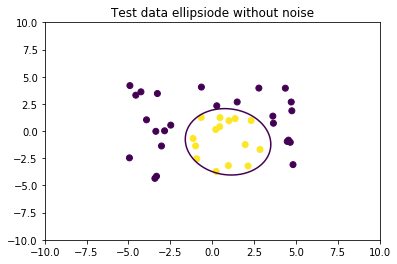

In [77]:
plot_ellipse1(A, c)
plot_scatter(Zx, Zy, isInEllipse)
plt.title("Test data ellipsiode without noise")

Text(0.5,1,'Test data ellipsiode with noise')

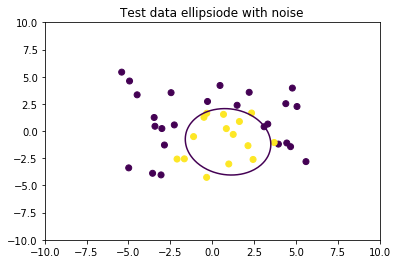

In [78]:
plot_ellipse1(A, c)
plot_scatter(ZxNoise, ZyNoise, isInEllipse)
plt.title("Test data ellipsiode with noise")

## Plotting test data f2

Text(0.5,1,'Test data ellipsiode without noise')

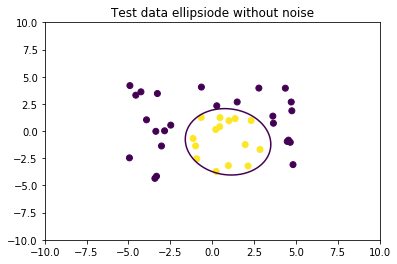

In [79]:
Xb = AandCtoX(A,c)
Xb, GAM = f1Xtof2X(Xb)
Ab, bb = xtoAandCorB(Xb)
plot_ellipse2(Ab, bb, GAM, xlim=10, ylim=10, resolution = 100)
plot_scatter(Zx, Zy, isInEllipse)
plt.title("Test data ellipsiode without noise")

Text(0.5,1,'Test data ellipsiode without noise')

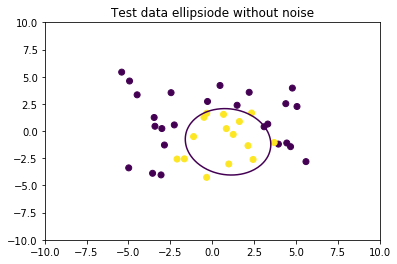

In [80]:
Xb = AandCtoX(A,c)
Xb, GAM = f1Xtof2X(Xb)
Ab, bb = xtoAandCorB(Xb)
plot_ellipse2(Ab, bb, GAM, xlim=10, ylim=10, resolution = 100)
plot_scatter(ZxNoise, ZyNoise, isInEllipse)
plt.title("Test data ellipsiode without noise")

In [81]:
# Plotting
def xtoAandCorB(X):
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    A = np.array([[X1,X2],[X2, X3]]).astype(float)
    vec = (np.array([X4,X5]).reshape(2,1)).astype(float)
    return A, vec

def plot_scatter(X, Y, classes, xlim = 10, ylim = 10):
    plt.scatter(X, Y, c=classes)
    plt.xlim(-xlim,xlim)
    plt.ylim(-ylim,ylim)
    plt.show()
    
def plot_ellipse1(A1, c1, xlim=10, ylim=10, npoints = 100):
    X = sym.Matrix([x1, x2])
    ellipse = (X - c1).T @ A1 @ (X - c1)
    f = sym.lambdify((x1, x2), ellipse[0], 'numpy')
    xp = np.linspace(-xlim,xlim, npoints)
    yp = np.linspace(-ylim,ylim, npoints)
    xmesh, ymesh = numpy.meshgrid(xp, yp)
    plt.contour(xmesh, ymesh, f(xmesh, ymesh), [1])
    
    
def plot_save(X, Y, A1, c1, funcNum, classes, plotname, xlim=10, ylim=10, npoints=100):
    #Saves the plot to a .jpg file taking the plot name as part of the input
    #print("These are the classes", classes)
    plt.scatter(X, Y, c=classes)
    plt.xlim(-xlim,xlim)
    plt.ylim(-ylim,ylim)
    X = sym.Matrix([x1, x2])
    if(funcNum == 1):
        ellipse = (X - c1).T @ A1 @ (X - c1)
    else:
        Xb = AandCtoX(A1,c1)
        Xb, GAM = f1Xtof2X(Xb)
        Ab, b1 = xtoAandCorB(Xb)
        ellipse = X.T @ Ab @ X - X.T @ b1 - sym.Matrix([[GAM]])
    f = sym.lambdify((x1, x2), ellipse[0], 'numpy')
    xp = np.linspace(-xlim,xlim, npoints)
    yp = np.linspace(-ylim,ylim, npoints)
    xmesh, ymesh = numpy.meshgrid(xp, yp)
    plt.contour(xmesh, ymesh, f(xmesh, ymesh), [1], colors = 'green')
    #Plots true ellipse
    if(funcNum == 1):
        trueEllipse = (X - c).T @ A @ (X - c)
    else:
        Xc = AandCtoX(A,c)
        Xc, gem = f1Xtof2X(Xc)
        Ac, bc = xtoAandCorB(Xc)
        trueEllipse = X.T @ Ac @ X - X.T @ bc - sym.Matrix([[gem]])
                                                       
                                                       
    ftrue = sym.lambdify((x1, x2), trueEllipse[0], 'numpy')
    plt.contour(xmesh, ymesh, ftrue(xmesh, ymesh),  [1], colors = 'red',)
    plt.savefig(directory+plotname+".jpg")
    
def linePlotListSegmenter(plotlist):
    #Takes the list of information that we wish to plot and subdivides it into smaller lists
    #print("This is plotlist in plotinfosegmenter", plotlist)
    xlist = []
    f1list = []
    logbarrierlist = []
    alfalist = []
    #print(int(len(plotlist)/4))
    for i in range(4, len(plotlist), 4):
        #print("This is plotlist element I", plotlist[i-1])
        xlist+=[plotlist[i-4]]
        f1list+=[plotlist[i-3]]
        logbarrierlist += [plotlist[i-2]]
        #print("This is the logbarrier value added to the list", [plotlist[i-2]])
        #print([plotlist[i+3]])
        alfalist+=[plotlist[i-1]]
    return xlist, f1list, logbarrierlist, alfalist

def sentinelRemover(list1):
    #Removes the sentinel values in a list
    for i in range(len(list1)):
        if(list1[i]=='sentinel'):
            list1[i]=0
    return list1

def linePlot(listOfPointsf1, listOfPointsf2, ylabel, title, logscale):
    plt.plot(listOfPointsf1, label = "f1")
    plt.plot(listOfPointsf2, label = "f2")
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.title(title)
    if(logscale):
        plt.yscale('log')
    plt.legend()
    plt.savefig(directory+title+".jpg")
    plt.show()
    

# Mathematical functions

In [112]:
def f2(X, Za, Zb):
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    res = 0
    for i in range(len(Za[0])):
        res += (np.maximum(RiWave.subs({z1: Za[0][i], z2: Za[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0))**2

    for i in range(len(Zb[0])):
        res += (np.minimum(RiWave.subs({z1: Zb[0][i], z2: Zb[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0))**2

    return res

In [113]:
def gradf2(X, Za, Zb):
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    res = np.array([[0,0,0,0,0]])
    for i in range(len(Za[0])):
        res += 2*np.maximum(RiWave.subs({z1: Za[0][i], z2: Za[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0)*gradRiWave.subs({z1: Za[0][i], z2: Za[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})

    
    for i in range(len(Zb[0])):
        res += 2*np.minimum(RiWave.subs({z1: Zb[0][i], z2: Zb[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0)*gradRiWave.subs({z1: Zb[0][i], z2: Zb[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})

    return res.T    

In [114]:
def f1(X, Za, Zb):
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    res = 0
    for i in range(len(Za[0])):
        res += (np.maximum(Ri.subs({z1: Za[0][i], z2: Za[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0))**2

    for i in range(len(Zb[0])):
        res += (np.minimum(Ri.subs({z1: Zb[0][i], z2: Zb[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0))**2

    return res

In [115]:
def gradf1(X, Za, Zb):
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    res = np.array([[0,0,0,0,0]])
    for i in range(len(Za[0])):
        res += 2*np.maximum(Ri.subs({z1: Za[0][i], z2: Za[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0)*gradRi.subs({z1: Za[0][i], z2: Za[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})

    
    for i in range(len(Zb[0])):
        res += 2*np.minimum(Ri.subs({z1: Zb[0][i], z2: Zb[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})[0]-1,0)*gradRi.subs({z1: Zb[0][i], z2: Zb[1][i], x1: X1, x2: X2, x3: X3, x4: X4, x5: X5})

    return res.T    

In [116]:
def logbarrier(X, mu, funcNum):
    X = np.array(X)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    consVal = 0.0
    
    consVal1 = constraint1.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0]
    consVal2 = constraint2.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0]
    consVal3 = constraint3.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0]
    consVal4 = constraint4.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0]
    consVal5 = constraint5.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0]

    if consVal1 < 1e-20:
        consVal1 = 1e-20
    if consVal2 < 1e-20:
        consVal2 = 1e-20
    if consVal3 < 1e-20:
        consVal3 = 1e-20
    if consVal4 < 1e-20:
        consVal4 = 1e-20
    if consVal5 < 1e-20:
        consVal5 = 1e-20
    
    consVal += log(consVal1)
    consVal += log(consVal2)
    consVal += log(consVal3)
    consVal += log(consVal4)
    consVal += log(consVal5)

    if(funcNum ==1):
        return f1(X, Za, Zb) - mu*consVal
    else:
        return f2(X, Za, Zb) - mu*consVal

In [117]:
def gradLogBarrier(x, muk, lam, funcNum):
    X = np.array(x)
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
        
    g5 = np.array([(X[2]/(2*(X[0]*X[2])**(1/2)))[0], -(X[1]/(X[1]**2 + y[0]**2)**(1/2)), X[0]/(2*(X[0]*X[2])**(1/2)), 0,0])
    gradCons = lam[0]*np.array(gradcons1).astype(float)[0].reshape(5,1)
    gradCons = gradCons + lam[1]*np.array(gradcons2).astype(float)[0].reshape(5,1)
    gradCons = gradCons + lam[2]*np.array(gradcons3).astype(float)[0].reshape(5,1)
    gradCons = gradCons + lam[3]*np.array(gradcons4).astype(float)[0].reshape(5,1)
    gradCons = gradCons + lam[4]*g5.reshape(5,1)
    
    if(funcNum==1):
        return gradf1(X, Za, Zb) - gradCons
    else:
        return gradf2(X, Za, Zb) - gradCons

        

# Helper functions

In [118]:
def columnNorm(X):
    val = 0
    for v in X:
        val += v**2
    return (val**(1/2))

In [299]:
def outOfSet(X):
    #Returns false if we are in the set and true if we are outside it
    X1, X2, X3, y1, y2 = X[0], X[1], X[2], y[0], y[1]
    try:
        #print(X)
        if(X1 < y1) or (X1 > y2):
            #print("1")
            return True
        if(X3 < y1) or (X3 > y2):
            #print("2")
            return True
        if(X1*X3 <0):
            #print("3")
            return True
        c5 = np.array(constraint5.subs({x1: X1, x2: X2, x3: X3, gamma1: y1}))[0]
        if(np.imag(c5)!=0):
            #print("4")
            return True
        if(c5<0):
            #print("5")
            #print(c5)
            return True

        return False
    except:
        print(X)
        return True


# Implementation of Primal Log-barrier with linesearch and quasi-newton BFGS

In [300]:
def zoom(alo, ahi, thet0, derThet0,xk, pk, amax, muk, lam, funcNum):
    repeating = True
    while repeating:
        #print("zooming", alo, ahi)
        aj = (alo + ahi)/2
        thetAj = logbarrier(xk+aj*pk, muk, funcNum)
        
        if(alo - ahi < 1e-8):
            return aj, False
        
        if thetAj > thet0 + c1*aj*derThet0 or thetAj >= logbarrier(xk+alo*pk, muk, funcNum):
            ahi = aj 
        else:
            derThetAj = ((gradLogBarrier(xk+aj*pk, muk, lam, funcNum).T) @ (pk))[0]
            if np.abs(derThetAj) <= -c2*derThet0:
                astar = aj
                return astar, False
            if derThetAj*(ahi - alo)>= 0:
                ahi = alo
            alo = aj


In [318]:
def linesearch(xk, pk, amax, muk, lam, funcNum):
    
    xnext = xk + amax*pk
    #print("Ainit is now", ainit)
    aLim = amax
    #Set Convex so ok :)
    while outOfSet(xnext):
        aLim = aLim*0.5
        xnext = xk+ aLim*pk
        if aLim<1e-18:
            return 0, True
            break
    amax = aLim
    
            
    ai = [0, 1e-16]
    i=1
    repeat = True  
    thet0 = logbarrier(xk, muk, funcNum)
    derThet0 = ((gradLogBarrier(xk, muk, lam, funcNum).T) @ (pk))[0]
    while repeat:
        if(ai[i]<1e-18):
            return 0, True
        #print("Line searching:", ai[i])
        thetAi = logbarrier(xk + ai[i] *pk, muk, funcNum)
        if thetAi > thet0 + c1*ai[i]*derThet0:
            astar, flag = zoom(ai[i-1], ai[i], thet0, derThet0,xk, pk, amax, muk, lam, funcNum)
            return astar, flag
        derThetAi = ((gradLogBarrier(xk+ai[i]*pk, muk, lam, funcNum).T) @ (pk))[0]
        if np.abs(derThetAi) <= - c2 * derThet0:
            astar = ai[i]
            return astar, False
        if derThetAi >= 0:
            astar, flag = zoom(ai[i], ai[i-1], thet0, derThet0,xk, pk, amax, muk, lam, funcNum)
            return astar, flag
        ai.append((ai[i]+amax)/2)
        i += 1
        if(np.abs(ai[i]-ai[i-1])<1e-7):
            return ai[i], True
                
        

In [319]:
def armijoBacktracking(xk, pk, muk, lam, ainit, funcNum):
    xnext = xk + ainit*pk
    #print("Ainit is now", ainit)
    aLim = ainit
    #Set Convex so ok :)
    while outOfSet(xnext):
        aLim = aLim*0.5
        xnext = xk+ aLim*pk
        if aLim<1e-25:
            aLim = 0;
            break
        
    aLim = aLim*0.99
    #print("Alim is", aLim)
    ainit = aLim
    
    
    
    fxapk = logbarrier(xk + ainit *pk, muk, funcNum)
    fxk = logbarrier(xk, muk, funcNum)
    gradxkpk = ((gradLogBarrier(xk, muk, lam, funcNum).T) @ (pk))[0]
    c1alfagradxkpk = (c1*ainit*gradxkpk)
    
    #print("c1*ainit*gradxkpk",c1, ainit, gradxkpk, c1*ainit*gradxkpk)
    #print("fxapk", fxapk)
    #print("fxk", fxk)
    #print("gradxkpk", gradxkpk)
    #print("c1alfagradxkpk", c1alfagradxkpk)
    #print("fxk + c1alfagradxkpk", fxk + c1alfagradxkpk)

    counter = 0
    while not fxapk <= fxk + c1alfagradxkpk:
        counter += 1
        ainit = contracFac * ainit
        c1alfagradxkpk = (c1*ainit*gradxkpk)
        fxapk = logbarrier(xk + ainit *pk, muk, funcNum)
        if counter>50:
            return ainit, True
        
    
    return ainit, False


        
    
    

In [320]:
def bfgs(X,muk, lam, tk, funcNum):
    xk = X.reshape(5,1)
    hk = np.identity(5)
    identity = np.identity(5)
    
    
    pointList =[]
    gradList = []
    hessList = []
    valueList = []
    
    counter = 0
    repeat = True
    while repeat:
        funcvalue = logbarrier(xk, muk, funcNum)
        print("This is the function value at the start of a bfgs iteration", funcvalue)
        valueList.append(funcvalue)
        grad = gradLogBarrier(xk, muk, lam, funcNum)
        
        if len(valueList)>2 and valueList[len(valueList)-1] == valueList[len(valueList)-2]:
            return xk, "sentinel"
        
        #print("ColumNorm(grad)", columnNorm(grad))
        if columnNorm(grad) < tk:
            return xk, "sentinel"
        
        #print("grad before in bfsg", grad)
        #print("xk before appending to pointlist", xk)
        pointList += [xk]
        gradList += [grad]
        hessList += [hk]
        pk = (-hk@grad).reshape(5,1)
        #print("This is pk found in BFGS linesearch", pk)
        #print("This is xk before linesearch", xk)
        #alfa, flag = armijoBacktracking(xk, pk, muk, lam, 5, funcNum)
        alfa, flag = linesearch(xk, pk, 5, muk, lam, funcNum)
        print("alfa found", alfa)
        if(alfa == 0 or flag):
            alfa, flag = armijoBacktracking(xk, pk, muk, lam, 5, funcNum)
            
        #print("alfa bfgs", alfa)
        #print("alfa*pk",alfa*pk)
        xk = (xk + alfa*pk).reshape(5,1)
        #print("xk", xk)

        
        #print("this is pointlist", pointList)
        sk = ((xk - pointList[counter]).reshape(5,1))
        #print("sk", sk)
        #print("xkproj", xk)

        yk =  (gradLogBarrier(xk, muk, lam, funcNum).reshape(5,1) - gradList[counter])
        
        #if not (sk.T @ yk)[0]> ((c2-1)*alfa*(grad.T)@pk)[0]:
        #    print("Curvature condition not satisfied")
        #    return xk, alfa
        
        #print("yk", (yk.T@sk)[0])
        rhok = (1/(yk.T@sk)[0])
        #print("rhok", rhok)
        hk = (identity - rhok*(sk@yk.T))@hk@(identity - rhok*(sk@yk.T)) + rhok*(sk@sk.T)
        #print("print hk is", hk)
        
        counter += 1
        
        if counter > 4 and np.abs(valueList[counter-2]/valueList[counter-1]) > 0.90:
            #print("Decrease slowing in bfgs")
            return xk, alfa

        if(counter == 30):
            return xk, alfa

In [321]:
def unconstrainedBarrierMethod(X, muInit, tInit, lam, plotname, funcNum):
    X1 = X.item(0,0)
    X2 = X.item(1,0)
    X3 = X.item(2,0)
    X4 = X.item(3,0)
    X5 = X.item(4,0)
    
    #List of values for each iteration for plotting. Values included are xk, f, logbarrier, and alfa
    plotlist=[]
    
    tk = tInit
    muk = muInit
    counter = 0
    
    repeat = True
    while repeat:
        #print("New iteration of unconstrained barrier method")
        #print("Logbarrier is", logbarrier(X, muk)), 
        print("function value is,", f1(X, Za, Zb))
        #print("X is,", X)
        #print("mu is", muk)
        
        
       
        # Plot
        if(counter%5==0 or counter == 1 or counter == 2):
            Ax, cx = xtoAandCorB(X)
            if(funcNum == 1):
                plot_ellipse1(Ax, cx, xlim = 10, ylim=10)
            else:
                Xb, GAM = f1Xtof2X(X)
                Ab, bb = xtoAandCorB(Xb)
                plot_ellipse2(Ab, bb, GAM, xlim=10, ylim=10, resolution = 100)
            plot_scatter(ZxNoise, ZyNoise, isInEllipse, xlim = 10, ylim=10)
            plot_save(ZxNoise, ZyNoise, Ax, cx, funcNum, isInEllipse, plotname + "f" + str(funcNum) +"_"+ str(counter), xlim = 10, ylim = 10, npoints = 100)
        
        # Run BFGS
        X, alfa = bfgs(X,muk, lam,tk, funcNum)
        X = np.array(X)
        X1 = X.item(0,0)
        X2 = X.item(1,0)
        X3 = X.item(2,0)
        X4 = X.item(3,0)
        X5 = X.item(4,0)
        
        plotlist += [X, f1(X, Za, Zb), logbarrier(X, muk, funcNum), alfa]
        
        # Update lagrangians
        lam[0] = muk/(constraint1.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0])
        lam[1]  = muk/(constraint2.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0])
        lam[2]  = muk/(constraint3.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0])
        lam[3]  = muk/(constraint4.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0])
        lam[4]  = muk/(constraint5.subs({x1: X1, x2: X2, x3:X3, x4:X4, x5:X5, gamma1: y[0], gamma2: y[1]})[0])

        # Final end condition
        if f1(X, Za, Zb) < 0.002:
            return X, plotlist, lam
        
        # Update penalizer and tolerance:
        muk = muk * 0.5
        tk = tk * 0.9
        print("Updating, lam:", lam, "mu: ", muk, tk)

        #End condition for testing
        #if(counter == 30):
        #    return X, plotlist, lam
        
        counter += 1

## Testing and plotting

In [322]:
Xinit = np.array([1,0,1,0,0]).reshape(5,1)

In [323]:
#Atest, ctest = xtoAandCorB(Xplot)
#plot_ellipse1(Atest, ctest, xlim = 10, ylim=10)
#plot_scatter(Zx, Zy, isInEllipse, xlim = 10, ylim=10)
#plot_save(Zx, Zy, Atest, ctest, isInEllipse,"test", xlim=10, ylim=10, npoints=100)

In [8]:
#Test case starting in true ellipse
x133= np.array([0.15396676, 0.01001539, 0.10774469, -0.98753949, 0.95254891]).reshape(5,1)
#F1
Q, listofstuff, lamf1 = unconstrainedBarrierMethod(x133, muInit, tInit, lamInit, "true_ellipse", 30)
#F2
W, listval, lamf2 = unconstrainedBarrierMethod(x133, muInit, tInit, lamInit, "true_ellipse", 2)


In [ ]:
xlistf1, f1list, logbarrierlistf1, alfalistf1 = linePlotListSegmenter(listofstuff)
xlistf2, f2list, logbarrierlistf2, alfalistf2 = linePlotListSegmenter(listval)


In [ ]:
alfalistf1 = sentinelRemover(alfalistf1)
alfalistf1 = sentinelRemover(alfalistf1)

In [ ]:
# Plotting alfa

linePlot(alfalistf1, alfalistf2, "Alfa", "Value of alfa at each iteration", True)

#plt.savefig("2i1.png")

In [ ]:
#Plotting function values
linePlot(f1list, f2list, "f1 value", "Value of f1 at each iteration", False)

In [ ]:
#Plotting logbarrier values
linePlot(logbarrierlistf1, logbarrierlistf2, "Log-barrier value", "Value of the log-barrier function at each iteration", True)

In [ ]:
def changeInXNorm(xlist):
    xnextToLast = xlist[-2]
    
    for i in range(len(xlist)-1):
        xlist[i] = columnNorm((xlist[i+1]-xlist[i]))[0]
    
    xlist[-1] = columnNorm((xlist[-1]-xnextToLast))[0]
    return xlist

In [ ]:
xlistf1 = changeInXNorm(xlistf1)
xlistf2 = changeInXNorm(xlistf2)

In [ ]:
#Plotting change in xnorm

linePlot(xlistf1, xlistf2, "Change in x-value", "Change in the xvalue after each iteration", False)

In [2]:
Test case starting at an arbitrary point in the set and away from the boundary
X2 = np.array([[1],
 [0],
 [1],
 [0], [0],]).reshape(5,1)

#F1
Q, listvaluesf1, lamf1 = unconstrainedBarrierMethod(X2, muInit, tInit, lamInit, "arbitrary_not_boundary", 1)
#F2
W, listvaluesf2, lamf2 = unconstrainedBarrierMethod(X2, muInit, tInit, lamInit, "arbitrary_not_boundary", 2)

In [90]:
xlistf1, f1list, logbarrierlistf1, alfalistf1 = linePlotListSegmenter(listvaluesf1)
xlistf2, f2list, logbarrierlistf2, alfalistf2 = linePlotListSegmenter(listvaluesf2)


In [91]:
alfalistf1 = sentinelRemover(alfalistf1)
alfalistf1 = sentinelRemover(alfalistf1)

In [3]:
# Plotting alfa

linePlot(alfalistf1, alfalistf2, "Alfa", "Value of alfa at each iteration", True)

#plt.savefig("2i1.png")

In [4]:
#Plotting function values
linePlot(f1list, f2list, "f value", "Value of f at each iteration", False)

In [5]:
#Plotting logbarrier values
linePlot(logbarrierlistf1, logbarrierlistf2, "Log-barrier value", "Value of the log-barrier function at each iteration", False)

In [98]:
xlistf1 = changeInXNorm(xlistf1)
xlistf2 = changeInXNorm(xlistf2)

In [6]:
#Plotting change in xnorm

linePlot(xlistf1, xlistf2, "Change in x-value", "Change in the x-value after each iteration", False)

In [7]:
#Test case starting near the boundary
X3 = np.array([[1e-1],[1e-5],[1e-1], [1], [1]]).reshape(5,1)
val, listval = unconstrainedBarrierMethod(X3, muInit, tInit, lamInit, "near_boundary")